In [46]:
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
housing_original=pd.read_csv("kc_house_data.csv")
housing_original.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Remove ID and Date
 - Looks like there is no empty / NULL data. 

In [48]:
housing_original=housing_original.drop(['id','date'],axis=1)
housing_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14)
memory usage: 3.1 MB


### Correlation of the features

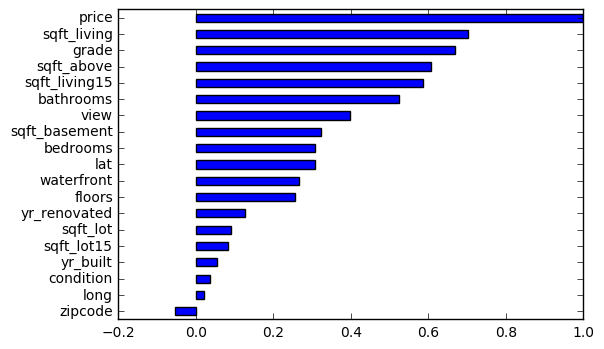

In [49]:
corr_matrix=housing_original.corr()
data1=corr_matrix.price.sort_values(ascending=True)
data1.plot.barh()
plt.show()

### Plot the histogram of all the features
- Categorical:
    - bathrooms
    - bedrooms
    - condition
    - floors
    - grade
    - view
    - waterfront
    - yr_renovated

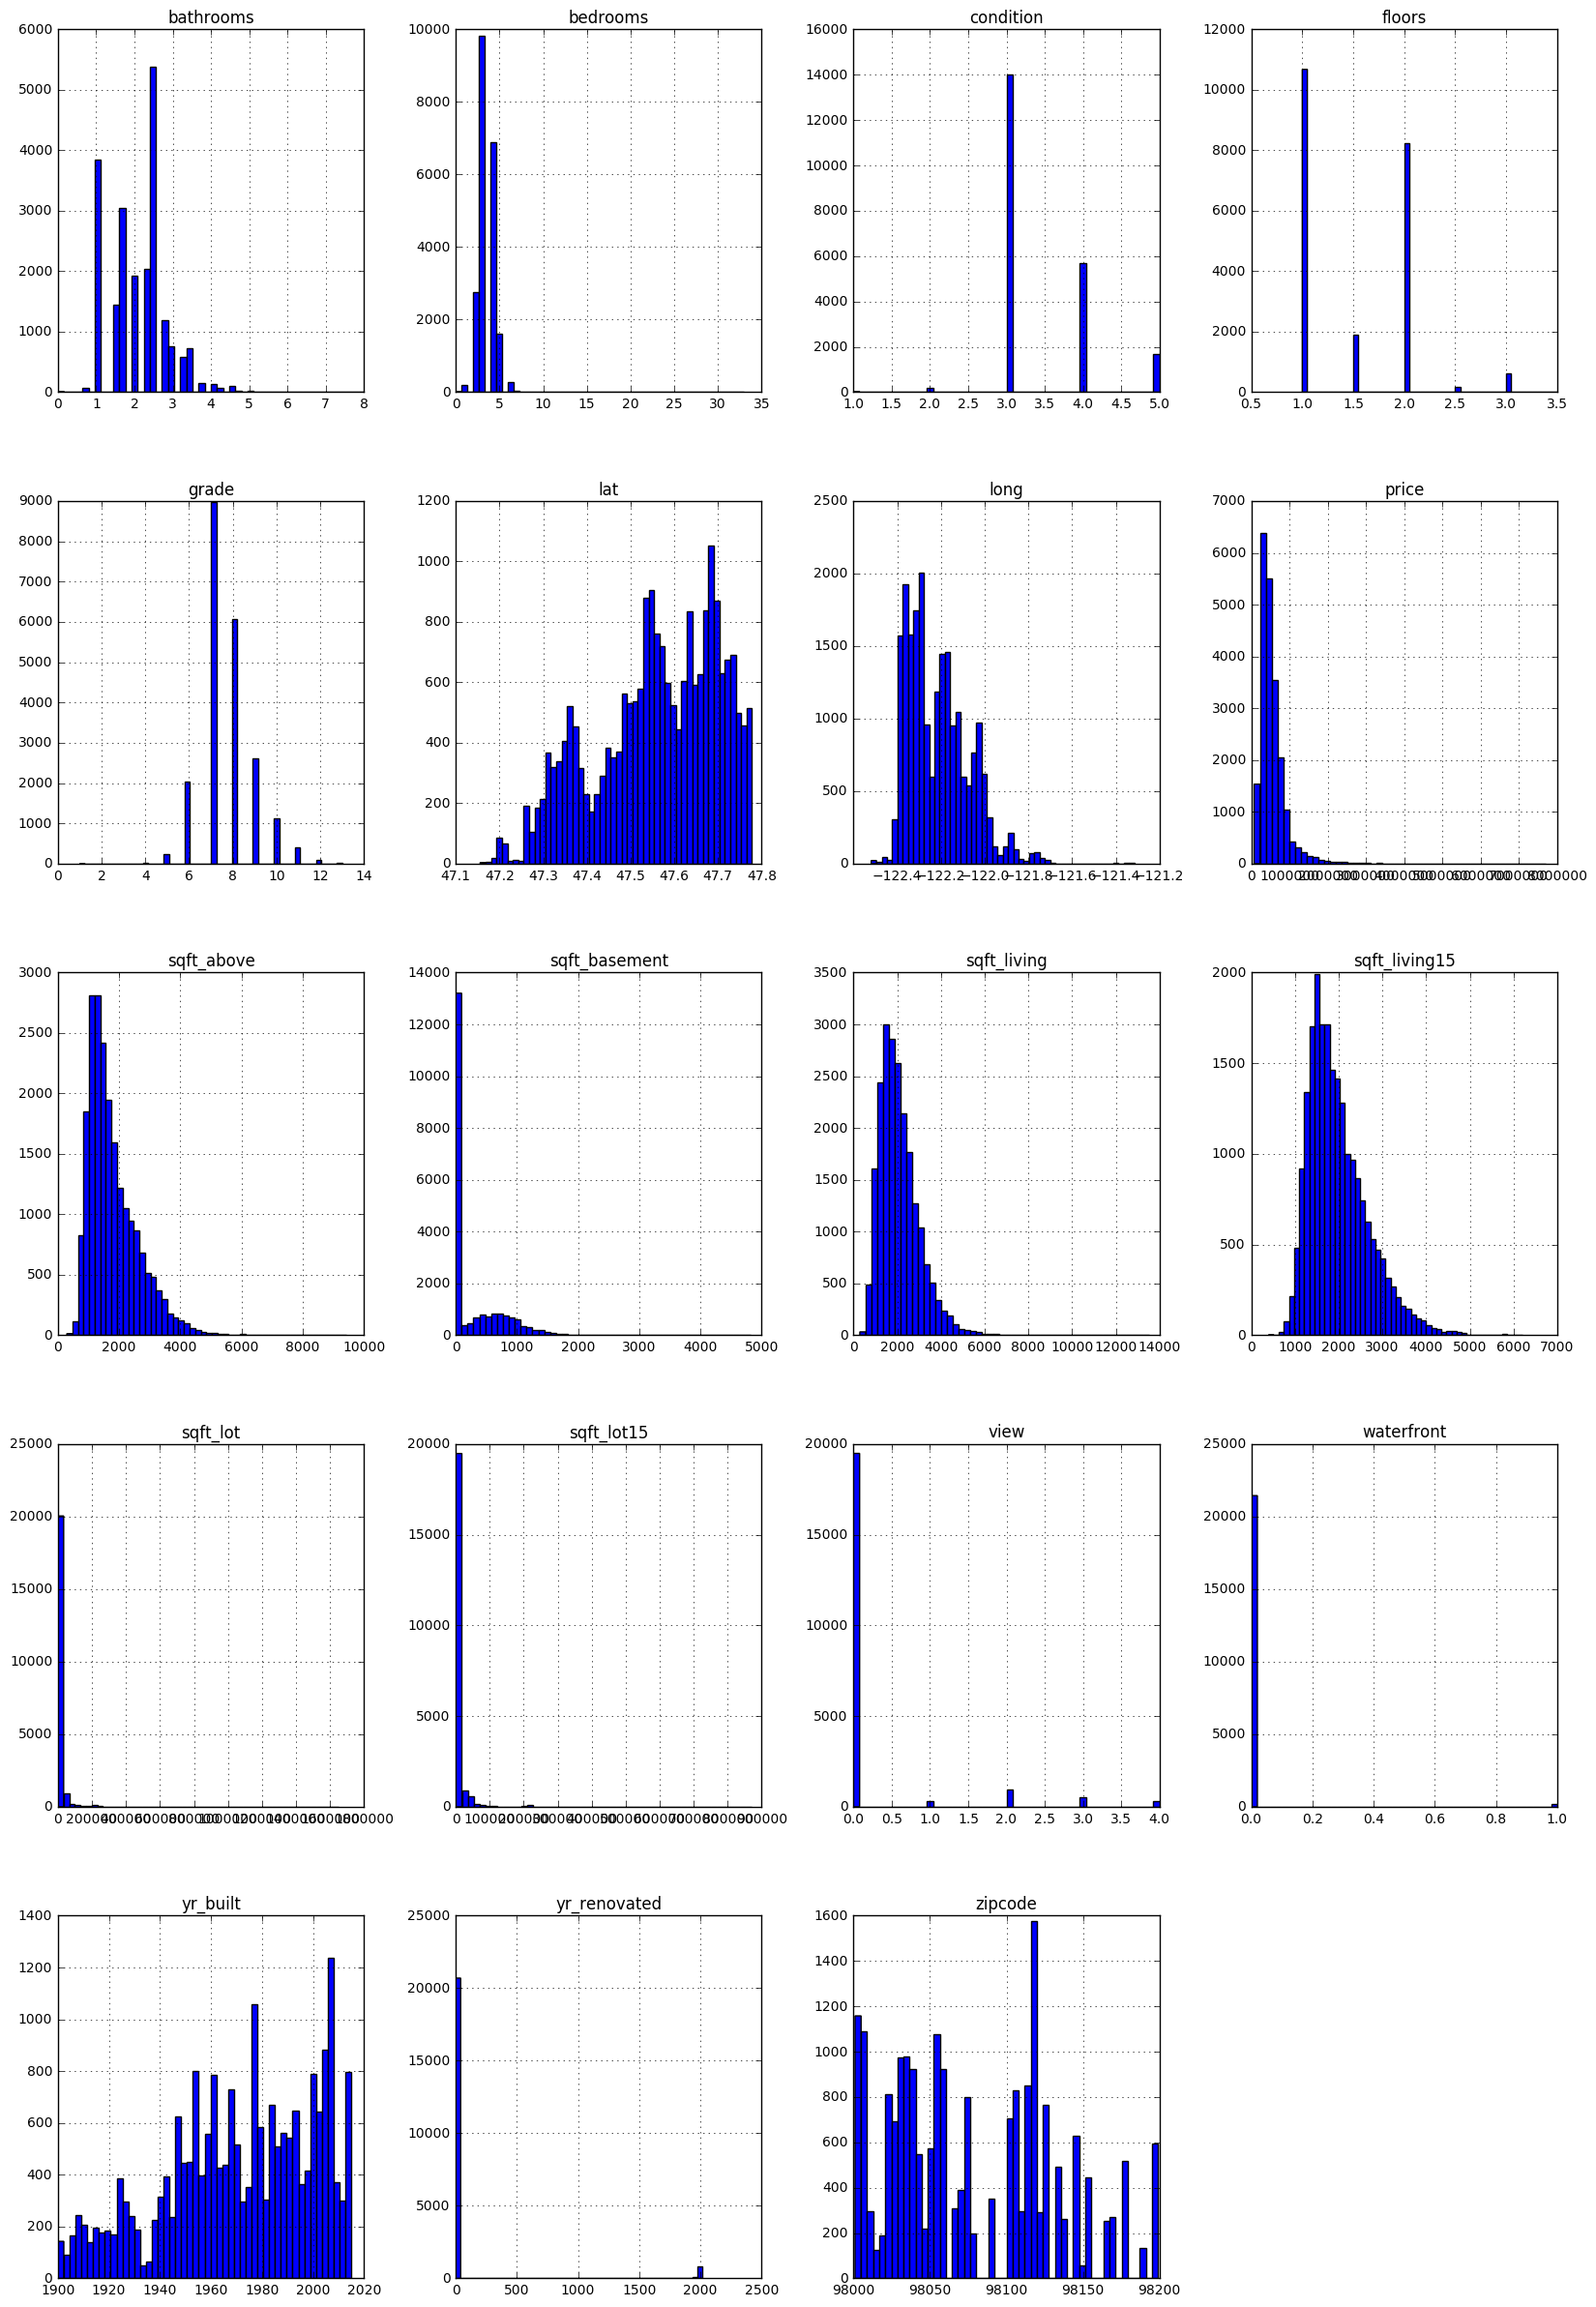

In [50]:
%matplotlib inline
housing_original.hist(bins=50,figsize=(20,30))
plt.show()

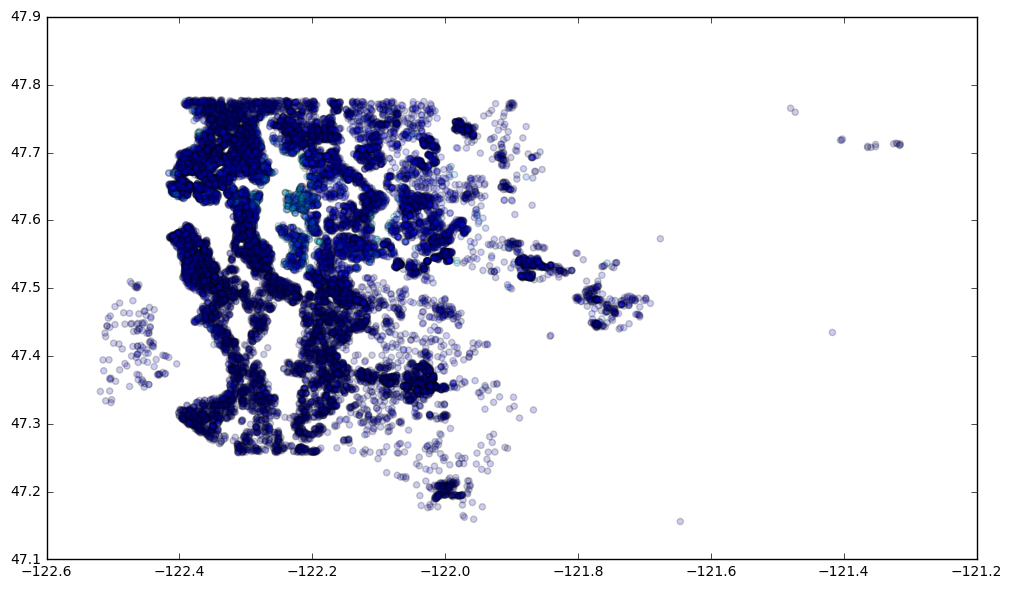

In [51]:
plt.figure(figsize=(12,7))
plt.scatter(housing_original.long,housing_original.lat,alpha=.2,cmap=plt.get_cmap("jet"),c=housing_original.price)
plt.show()

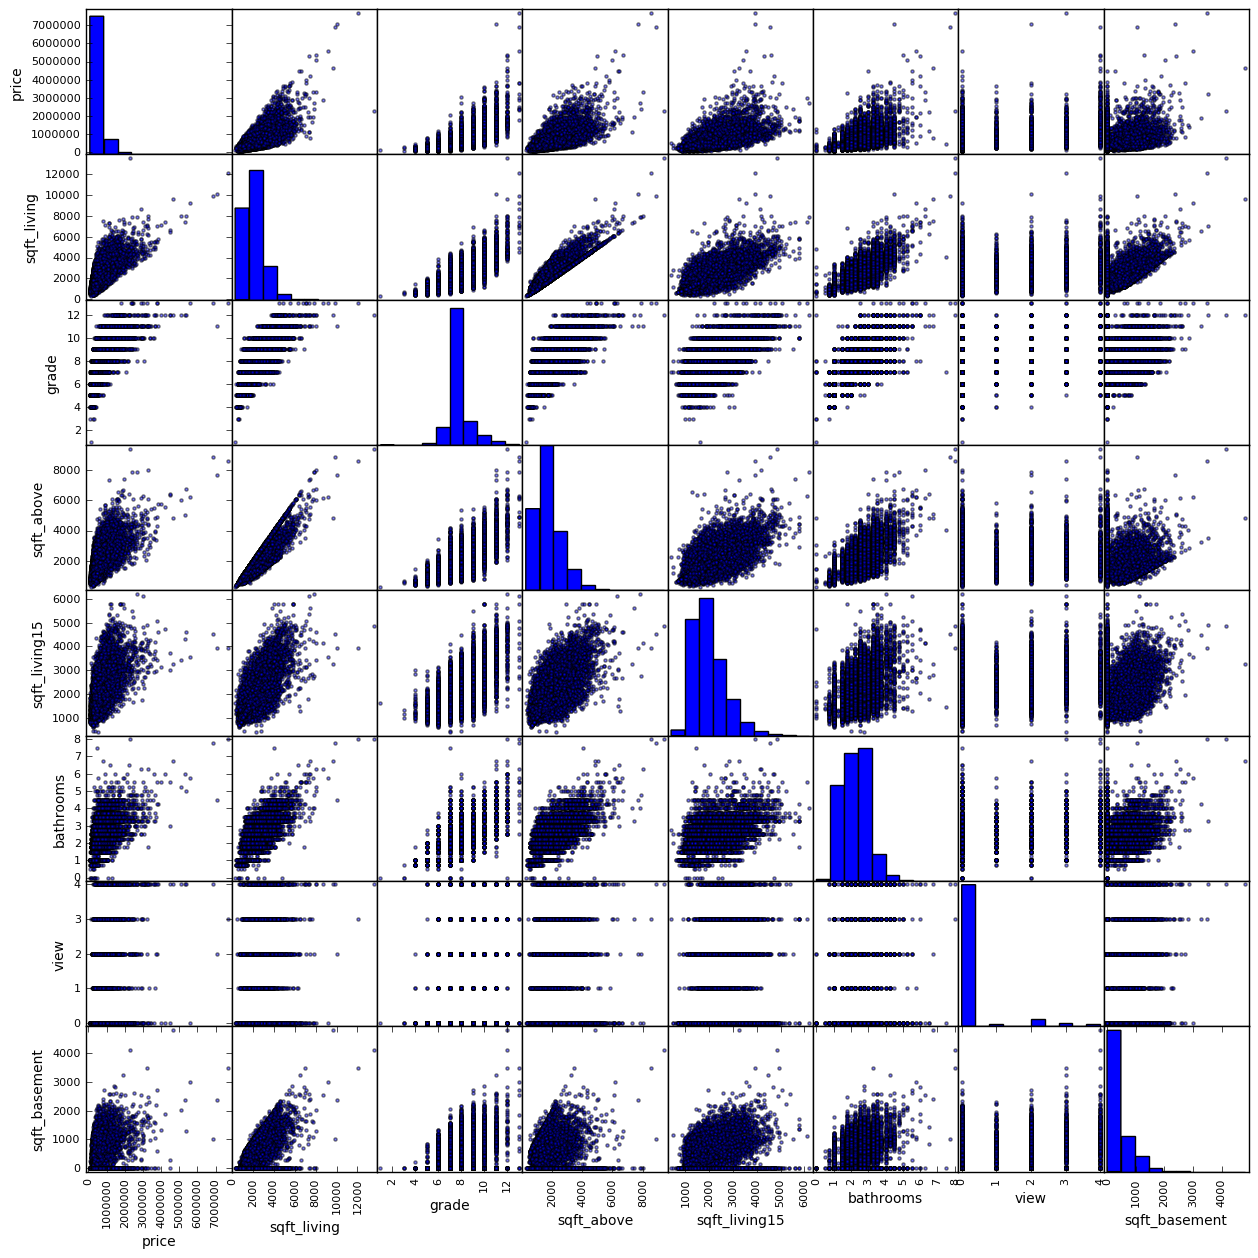

In [52]:
from pandas.tools.plotting import scatter_matrix

attrib=["price","sqft_living", "grade", "sqft_above",
              "sqft_living15","bathrooms","view","sqft_basement"]

scatter_matrix(housing_original[attrib],figsize=(15,15))
plt.show()

### Create Train & Test Data Set

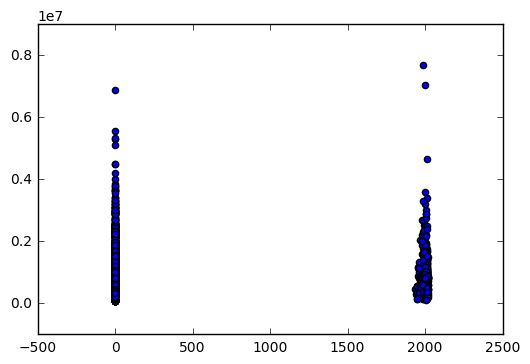

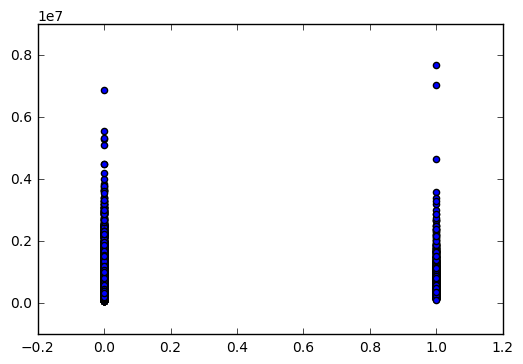

In [53]:
plt.scatter(housing_original.yr_renovated,housing_original.price)
plt.show()
housing_original["renovated"]=housing_original['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
plt.scatter(housing_original.renovated,housing_original.price)
plt.show()

housing_original=housing_original.drop("yr_renovated",axis=1)

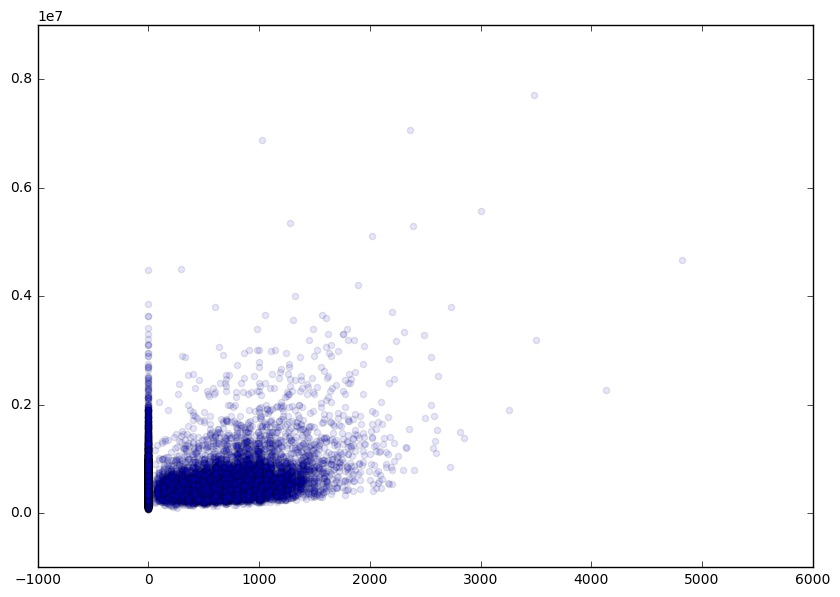

In [73]:
plt.figure(figsize=(10,7))
plt.scatter(housing_original.sqft_basement,housing_original.price,alpha=.1)
plt.show()

housing_original["has_basement"]=housing_original.sqft_basement.apply(lambda x: 1 if x > 0 else 0)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

#dummies = pd.get_dummies(housing_original.floors, drop_first=False)
#dummies = dummies.add_prefix("{}#".format('floors'))
#housing_original.drop('floors', axis=1, inplace=True)
#housing_original = housing_original.join(dummies)

train_set,test_set=train_test_split(housing_original,test_size=.3,random_state=40)

# Initial Prediction

### Create the pipeline

In [108]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as pp

from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    
    def fit(self,X,y=None):
        return self;
    
    def transform(self,X):
        return X[self.attribute_names].values


housing_train_X=train_set.drop('price',axis=1)
train_y=train_set.price.as_matrix()

housing_test_X=test_set.drop('price',axis=1)
test_y=test_set.price.as_matrix()

#cat_cols=['condition','grade','view','floors#1.0','floors#1.5','floors#2.0','floors#2.5','floors#3.0','floors#3.5']
cat_cols=['condition','grade','view','floor','sqft_basement']
cat_col1=['condition']
cat_col2=['grade']
cat_col3=['view']
cat_col4=['floor']

contd_cols=list(housing_train_X.drop(cat_cols,axis=1))

contd_pipe=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(list(contd_cols))),
    ('std_scaler',pp.StandardScaler())
])

cat_pipe1=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col1)),
    ('label_binarizer',pp.LabelBinarizer())
])
cat_pipe2=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col2)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe3=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col3)),
    ('label_binarizer',pp.LabelBinarizer())
])

cat_pipe4=pipeline.Pipeline([
    ('DataFrameSelector',DataFrameSelector(cat_col4)),
    ('label_binarizer',pp.LabelBinarizer())
])


full_pipeline=pipeline.FeatureUnion(transformer_list=[
    ("contd_pipe",contd_pipe),
    ("cat_pipe1",cat_pipe1),
    ("cat_pipe2",cat_pipe2),
    ("cat_pipe3",cat_pipe3),
    #("cat_pipe4",cat_pipe4),
])


train_X=full_pipeline.fit_transform(housing_train_X)
test_X=full_pipeline.fit_transform(housing_test_X)

housing=pd.DataFrame(test_X)

housing.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.639106,1.792475,1.907441,-0.165417,0.942480,-0.091641,1.600960,1.469423,-1.396919,0.264379,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.639106,0.499336,0.731185,0.035368,0.942480,-0.091641,1.155207,0.621116,-0.068531,0.157547,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.378567,0.499336,-0.183681,1.436389,0.942480,-0.091641,0.143228,0.892574,-1.022725,-0.175304,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.378567,-0.147233,-0.379724,0.671776,-0.921211,-0.091641,-0.073625,0.892574,-0.760790,-1.062663,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.656779,1.145906,0.371773,-0.101426,0.942480,-0.091641,0.757644,1.435491,1.259857,-0.395509,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Run the models

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def run_random_forest(train_X,train_y,test_X,test_y):
    #tree=RandomForestRegressor(bootstrap=True,
           #max_features=12,  n_estimators=200, n_jobs=-1)
        
    for n in range(99, 100):

        tree=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=True, verbose=0, warm_start=False)
    #RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    #       max_features=12, max_leaf_nodes=None, min_impurity_split=1e-07,
    #       min_samples_leaf=1, min_samples_split=2,
    #       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
    #       oob_score=False, random_state=None, verbose=0, warm_start=False)
    
        tree.fit(train_X,train_y)
        print(n," -> Train Set Score = ",tree.score(train_X,train_y)," , Test Set Score = ",tree.score(test_X,test_y))
    
run_random_forest(train_X,train_y,test_X,test_y)

In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100,200], 'max_features': [20, 25, 30, 35]}
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=20,n_jobs=-1)

grid_search.fit(train_X,train_y)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 20, 'n_estimators': 200}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [88]:
print(grid_search.best_estimator_.feature_importances_)

[  4.41332407e-03   3.20674006e-02   3.73930412e-01   1.61746964e-02
   2.53303424e-03   2.86875327e-02   8.14561280e-02   2.18586048e-02
   2.17955028e-02   1.71181267e-01   6.53297317e-02   1.02803122e-01
   1.73190230e-02   1.90855294e-03   2.29962617e-03   8.05991860e-05
   2.36007087e-04   1.61861633e-03   1.28968211e-03   1.17003333e-03
   8.53145498e-07   1.62732557e-05   8.86164567e-05   8.22769207e-04
   4.97380427e-03   4.65829014e-03   5.12411819e-03   5.55093218e-03
   4.00327175e-03   3.60090669e-03   1.15265575e-03   9.50382354e-03
   5.88436711e-04   9.18330352e-04   1.32321431e-03   9.52080710e-03]


### Optimize the model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
cross_val_score(tree, train_X, train_y, cv=20,n_jobs=-1)

#metrics.accuracy_score(train_y, predicted)